In [13]:
import pandas as pd
import numpy as np

df=pd.read_csv("IMDb Movies India.csv",encoding='ISO-8859-1')
print(df.head().to_string())

                                 Name    Year Duration            Genre  Rating Votes            Director       Actor 1             Actor 2          Actor 3
0                                         NaN      NaN            Drama     NaN   NaN       J.S. Randhawa      Manmauji              Birbal  Rajendra Bhatia
1  #Gadhvi (He thought he was Gandhi)  (2019)  109 min            Drama     7.0     8       Gaurav Bakshi  Rasika Dugal      Vivek Ghamande    Arvind Jangid
2                         #Homecoming  (2021)   90 min   Drama, Musical     NaN   NaN  Soumyajit Majumdar  Sayani Gupta   Plabita Borthakur       Roy Angana
3                             #Yaaram  (2019)  110 min  Comedy, Romance     4.4    35          Ovais Khan       Prateik          Ishita Raj  Siddhant Kapoor
4                   ...And Once Again  (2010)  105 min            Drama     NaN   NaN        Amol Palekar  Rajat Kapoor  Rituparna Sengupta      Antara Mali


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Data preprocessing 
# Drop rows with missing Rating
df_clean = df.dropna(subset=["Rating"]).copy()

# Fill missing values in categorical columns with "Unknown"
for col in ["Genre", "Director", "Actor 1", "Actor 2", "Actor 3"]:
    df_clean[col] = df_clean[col].fillna("Unknown")

# Clean 'Votes' column and convert to numeric
df_clean["Votes"] = df_clean["Votes"].str.replace(",", "").astype(float)
print(df_clean.head().to_string())


                                 Name    Year Duration                      Genre  Rating   Votes        Director          Actor 1                 Actor 2          Actor 3
1  #Gadhvi (He thought he was Gandhi)  (2019)  109 min                      Drama     7.0     8.0   Gaurav Bakshi     Rasika Dugal          Vivek Ghamande    Arvind Jangid
3                             #Yaaram  (2019)  110 min            Comedy, Romance     4.4    35.0      Ovais Khan          Prateik              Ishita Raj  Siddhant Kapoor
5                ...Aur Pyaar Ho Gaya  (1997)  147 min     Comedy, Drama, Musical     4.7   827.0    Rahul Rawail       Bobby Deol  Aishwarya Rai Bachchan    Shammi Kapoor
6                           ...Yahaan  (2005)  142 min        Drama, Romance, War     7.4  1086.0  Shoojit Sircar  Jimmy Sheirgill          Minissha Lamba   Yashpal Sharma
8                  ?: A Question Mark  (2012)   82 min  Horror, Mystery, Thriller     5.6   326.0   Allyson Patel        Yash Dave          

In [15]:
# Select features and target
features = ["Genre", "Director", "Actor 1", "Actor 2", "Actor 3", "Votes"]
target = "Rating"

X = df_clean[features]
y = df_clean[target]

# Define preprocessing for categorical columns
categorical_features = ["Genre", "Director", "Actor 1", "Actor 2", "Actor 3"]
numeric_features = ["Votes"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", max_categories=100), categorical_features),
        ("num", "passthrough", numeric_features)
    ]
)

In [16]:
# Define and train model pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split data and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.head().to_string())
pipeline.fit(X_train, y_train)


                                 Genre      Director        Actor 1             Actor 2         Actor 3    Votes
8157                     Comedy, Drama  Ronit Jadhav   Ronit Jadhav       Rohit D'Souza  Darshil Gandhi     10.0
8455                             Drama   Shibu Mitra  Shashi Kapoor                Pran      Amjad Khan     16.0
14490                       Drama, War    Kabir Khan    Salman Khan         Sohail Khan         Om Puri  17774.0
2697                            Action  Gautam Verma     Rajat Bedi  Mithun Chakraborty   Dinesh Hingoo     17.0
15470  Documentary, Biography, Musical    Sandip Ray  Kishore Kumar    Amitabh Bachchan     Asha Bhosle     33.0


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                max_categories=100),
                                                  ['Genre', 'Director',
                                                   'Actor 1', 'Actor 2',
                                                   'Actor 3']),
                                                 ('num', 'passthrough',
                                                  ['Votes'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [17]:
# Predict and evaluate
from sklearn.metrics import mean_squared_error
y_pred = pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

1.2441597361735879


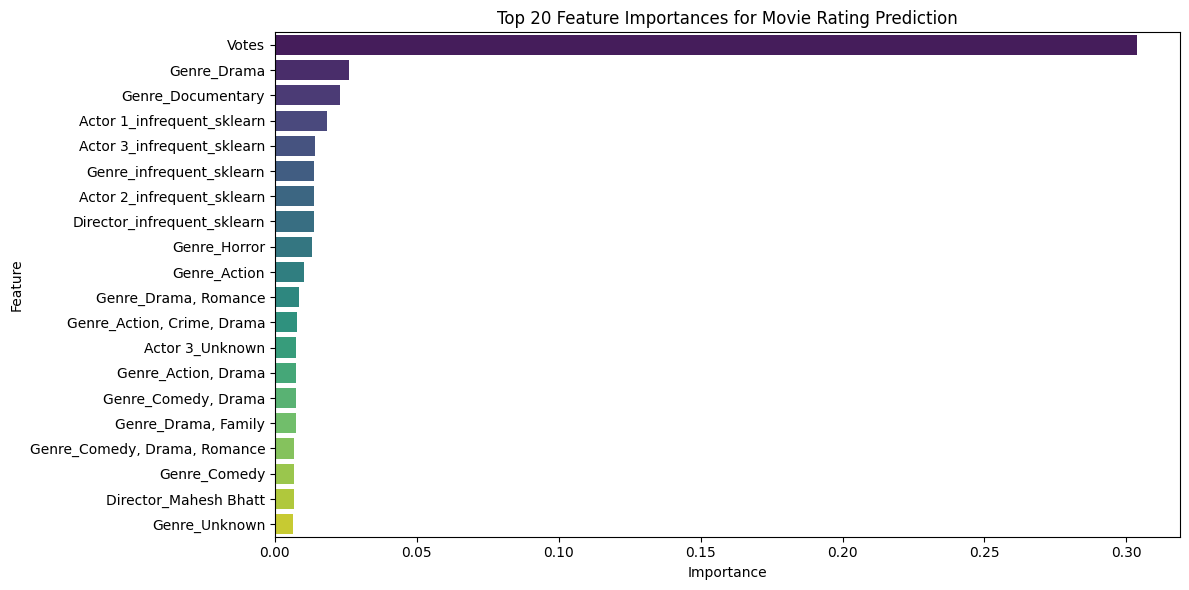

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
# Feature importances
ohe_feature_names = pipeline.named_steps["preprocessor"].transformers_[0][1].get_feature_names_out(categorical_features)
all_feature_names = list(ohe_feature_names) + numeric_features
importances = pipeline.named_steps["regressor"].feature_importances_

# Create dataframe and plot
feat_imp_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(data=feat_imp_df, x="Importance", y="Feature", hue="Feature", palette="viridis")
plt.title("Top 20 Feature Importances for Movie Rating Prediction")
plt.tight_layout()
plt.show()